In [84]:
include("BTG_main.jl")
include("kernels/kernel.jl")

KernelMat (generic function with 1 method)

In [85]:
function test_fun_1d(x)
    return sin(x) + 1.1
end

# training points
x_train = [-4, -3, -2, 0, 1, 2, 3, 4]
y_train = test_fun_1d.(x_train) 
n_train = size(x_train,1)
training_data = [x_train, y_train]

# Test data
x_test = range(-5, stop = 5, step = 0.23)
y_test = test_fun_1d.(x_test) 
testing_data = [x_test, y_test];

# model setting
kernel = kernel_BTG
nonlinfun = BoxCox


BoxCox (generic function with 2 methods)

In [86]:
i = 4
x0 = x_test[i, :]
z_true = y_test[i]

2.0201280537556237

In [87]:
distribution_temp, alpha = model(x0, training_data, kernel, nonlinfun);

InterruptException: InterruptException:

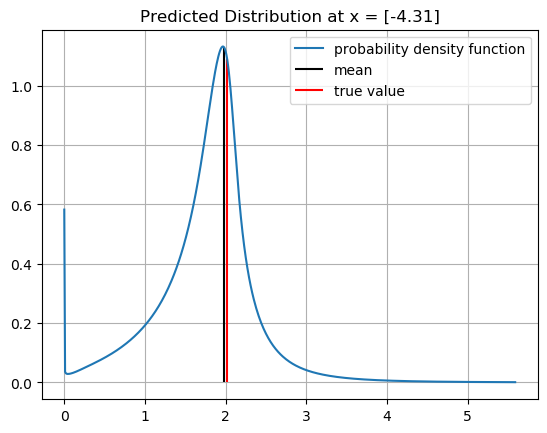

PyObject Text(0.5, 1, 'Predicted Distribution at x = [-4.31]')

In [76]:
pdf_temp = distribution_temp.pdf
plot_distribution_single(distribution_temp, x0, z_true)

In [77]:
pdf_temp(1e-10)

102.54738738319462

In [88]:
# compute p(z0|z)
function pdf_z0(x0, z0, trainBasicInfo, sideSetInfo, param_gridInfo, alpha, Gamma)
    # extract 
    theta_grid = param_gridInfo.theta.grid
    lambda_grid = param_gridInfo.lambda.grid
    L_Set = sideSetInfo.L
    XSX_Set = sideSetInfo.XSX
    gz_Set = sideSetInfo.gz
    q_Set = sideSetInfo.q
    Beta_Set = sideSetInfo.Beta

    n_theta = size(theta_grid, 1)
    n_lambda = size(lambda_grid, 1)
    
    p_z0 = 0.0
    
    for i in 1:n_theta, j in 1:n_lambda 
        tempsideInfo = (L = L_Set[i, j, :, :], 
                    XSX = XSX_Set[i, j, :, :], 
                    gz = gz_Set[i, j, :], 
                    q = q_Set[i, j], 
                    Beta = Beta_Set[i, j, :])
        p_z0_sample = pdf_z0_ij(theta_grid[i, :], lambda_grid[j], x0, z0,
                                trainBasicInfo, tempsideInfo, Gamma)
        step = alpha[i, j] * p_z0_sample 
        p_z0 += step
        println("At [$i, $j], step = $step")
        println("  alpha = $(alpha[i,j]), pdfij = $p_z0_sample")
    end
    
    return p_z0

end


function pdf_z0_ij(theta_sample, lambda_sample, x0, z0, trainBasicInfo, sideInfo, Gamma)
    x = trainBasicInfo.data[1]
    z = trainBasicInfo.data[2]
    g = trainBasicInfo.nonlintrans.fun
    dg = trainBasicInfo.nonlintrans.deriv
    kernel = trainBasicInfo.kernel
    p = trainBasicInfo.polydof

    X = meanbasisMat(x, p) # n * p
    X0 = meanbasisMat(x0, p) # k * p
    n = size(x, 1)
    k = size(x0, 1)

    L = sideInfo.L # n * n
    XSigmaX = sideInfo.XSX # p * p
    gz = sideInfo.gz # n * 1
    q = sideInfo.q # 1 * 1
    Beta = sideInfo.Beta # p * 1

    B = KernelMat(x0, x, kernel, theta_sample) # k * n
    E = KernelMat(x0, x0, kernel, theta_sample) # k * k

    # compute m
    BinvS = (B / L') / L # k * n
    H = X0[1] - (BinvS * X)[1] # k * p 
    m = (BinvS * gz)[1] + H * Beta[1]
    # compute C 
    D = E[1] - (BinvS * B')[1]
    C = D + H / (XSigmaX[1]) * H

    
    # cpmpute p(z0|theta, lambda, z)
    dg_new = z -> dg(z, lambda_sample)
    gz0 = g(z0, lambda_sample) - m 
#     p_z0_sample = Gamma * sqrt(( 1+ (gz0'/C*gz0)/q ) ^(p-n-k)) * abs(dg_new(z0)) * 1/sqrt(q*det(C))
    
    println("q = $q, C = $C")
    println("gz0 = $gz0, dJ = $(dg_new(z0))")
    
    p_z0_sample = Gamma * sqrt( (1+gz0^2/(C*q))^(p-n-k) ) * abs(dg_new(z0)) * 1/sqrt(q*det(C))
    return p_z0_sample
end

pdf_z0_ij (generic function with 1 method)

In [89]:
x = training_data[1]
z = training_data[2]
p = 1
# define nonlinear transformation
# both function values and derivatives
g =  (x, lambda) -> nonlinfun(x, lambda)[1]
dg = (x, lambda) -> nonlinfun(x, lambda)[2]

# define polynomial basis
X = meanbasisMat(x, p)
X0 = meanbasisMat(x0, p)

# precompute the constant coefficient in p(z0|z)
n = size(x, 1) # #training points
k = size(x0, 1) # #predicting points
Gamma = gamma((n-p+k)/2)/(gamma((n-p)/2) * pi^(k/2))

# wrap up basic training info
traindata = (idx = x, val = z)
nonlintrans = (fun = g, deriv = dg)
trainBasicInfo = (data = training_data, kernel = kernel, 
                polydof = p, nonlintrans = nonlintrans)

## compute weights
# compute quadrature grids and weights
n_quad = [8, 8, 9] # number of quad nodes for each param, could increase if needed
n_theta = [n_quad[1], n_quad[2]]
n_lambda = n_quad[3]
n_param = (theta = n_theta, lambda = n_lambda)
param_gridInfo = param_grid_comp(n_param, param_priorInfo)


(theta = (grid = [0.019855071751231856 0.03971014350246371; 0.019855071751231856 0.20333352258637327; … ; 0.9801449282487682 1.7966664774136267; 0.9801449282487682 1.9602898564975364], wt = [0.005123608279746062, 0.01125565330822747, 0.015878032293391048, 0.018356974263823825, 0.018356974263823825, 0.015878032293391048, 0.01125565330822747, 0.005123608279746062, 0.01125565330822747, 0.02472666224227646  …  0.02472666224227646, 0.01125565330822747, 0.005123608279746062, 0.01125565330822747, 0.015878032293391048, 0.018356974263823825, 0.018356974263823825, 0.015878032293391048, 0.01125565330822747, 0.005123608279746062]), lambda = (grid = [-2.904480718522878, -2.5080933219799073, -1.840114298101771, -0.9727602702114267, 0.0, 0.9727602702114267, 1.840114298101771, 2.5080933219799073, 2.904480718522878], wt = [0.24382316508472313, 0.5419444820845722, 0.7818320892088062, 0.9370412311200083, 0.9907180650037793, 0.9370412311200083, 0.7818320892088062, 0.5419444820845722, 0.24382316508472313])

In [90]:
param_gridInfo.lambda.grid

9-element Array{Float64,1}:
 -2.904480718522878 
 -2.5080933219799073
 -1.840114298101771 
 -0.9727602702114267
  0.0               
  0.9727602702114267
  1.840114298101771 
  2.5080933219799073
  2.904480718522878 

In [91]:
alpha, sideSetInfo = weight_comp(param_gridInfo, param_priorInfo, trainBasicInfo);

In [92]:
z0 = 1e-10
pdf_z0(x0, z0, trainBasicInfo, sideSetInfo, param_gridInfo, alpha, Gamma)

q = 1556.5345280758731, C = 1.106104339582128
gz0 = -3.8171452627201344e28, dJ = 1.1086824815371578e39
At [1, 1], step = 0.0
  alpha = 9.111616606432163e-14, pdfij = 0.0
q = 559.618839778357, C = 1.106104339582128
gz0 = -4.8038509938297103e24, dJ = 1.2048506597410785e35
At [1, 2], step = 0.0
  alpha = 7.267880606469589e-12, pdfij = 0.0
q = 112.14026833619819, C = 1.106104339582128
gz0 = -1.3686682133933007e18, dJ = 2.51850594882241e28
At [1, 3], step = 1.2889426521252043e-118
  alpha = 2.9108783246749557e-9, pdfij = 4.4280196846398057e-110
q = 19.34086004402049, C = 1.106104339582128
gz0 = -5.490310133165784e9, dJ = 5.340755570203755e19
At [1, 4], step = 4.885949299594901e-60
  alpha = 1.6374558234498388e-6, pdfij = 2.983866330696509e-54
q = 5.321010647557873, C = 1.106104339582128
gz0 = -22.968491734609596, dJ = 1.0e10
At [1, 5], step = 0.009862327981733695
  alpha = 0.00015850638575777988, pdfij = 62.22038269678752
q = 3.519048287434301, C = 1.106104339582128
gz0 = -1.229155255506979

At [7, 2], step = 0.0
  alpha = 1.6145223946160904e-11, pdfij = 0.0
q = 110.33282096682203, C = 0.6349860448779225
gz0 = -1.3686682133933007e18, dJ = 2.51850594882241e28
At [7, 3], step = 3.885177754024546e-119
  alpha = 6.4790613838011395e-9, pdfij = 5.9965132661626176e-111
q = 18.994883385318065, C = 0.6349860448779225
gz0 = -5.490310133776224e9, dJ = 5.340755570203755e19
At [7, 4], step = 1.4727405814288475e-60
  alpha = 3.6677153352514543e-6, pdfij = 4.015416810770234e-55
q = 5.206971629735591, C = 0.6349860448779225
gz0 = -23.384829609672472, dJ = 1.0e10
At [7, 5], step = 0.002627511407081086
  alpha = 0.00035955635833752954, pdfij = 7.307648289769747
q = 3.4356453991980533, C = 0.6349860448779225
gz0 = -1.6311180952155222, dJ = 100000.0
At [7, 6], step = 4.141442819907965
  alpha = 0.0014574533626752412, pdfij = 2841.5611270786076
q = 4.281561856431114, C = 0.6349860448779225
gz0 = -1.4148870081731726, dJ = 100000.0
At [7, 7], step = 3.8251708354376968
  alpha = 0.000562821712094

q = 8.307988580787448, C = 0.5512154553053323
gz0 = -1.776346005300686, dJ = 100000.0
At [14, 9], step = 0.3406811163264376
  alpha = 5.82512956875367e-5, pdfij = 5848.472764517904
q = 1557.118802186832, C = 0.43633847064517706
gz0 = -3.8171452627201344e28, dJ = 1.1086824815371578e39
At [15, 1], step = 0.0
  alpha = 4.578844045658916e-13, pdfij = 0.0
q = 559.5389652480749, C = 0.43633847064517706
gz0 = -4.8038509938297103e24, dJ = 1.2048506597410785e35
At [15, 2], step = 0.0
  alpha = 3.6589429086474863e-11, pdfij = 0.0
q = 111.83546230318403, C = 0.43633847064517706
gz0 = -1.3686682133933007e18, dJ = 2.51850594882241e28
At [15, 3], step = 2.500693154628913e-119
  alpha = 1.4787410151045888e-8, pdfij = 1.6910960939647996e-111
q = 19.09715033477745, C = 0.43633847064517706
gz0 = -5.490310133869911e9, dJ = 5.340755570203755e19
At [15, 4], step = 9.479289039492672e-61
  alpha = 8.613421990887872e-6, pdfij = 1.1005253254189566e-55
q = 5.142117754761816, C = 0.43633847064517706
gz0 = -23.46

q = 1673.802125014899, C = 0.5305086625814976
gz0 = -3.8171452627201344e28, dJ = 1.1086824815371578e39
At [21, 1], step = 0.0
  alpha = 1.0404789333221462e-12, pdfij = 0.0
q = 601.3001853432779, C = 0.5305086625814976
gz0 = -4.8038509938297103e24, dJ = 1.2048506597410785e35
At [21, 2], step = 0.0
  alpha = 8.322577457374561e-11, pdfij = 0.0
q = 119.81703524512852, C = 0.5305086625814976
gz0 = -1.3686682133933007e18, dJ = 2.51850594882241e28
At [21, 3], step = 1.4501653954340167e-118
  alpha = 3.3995483967185656e-8, pdfij = 4.26575893678642e-111
q = 20.16647033688229, C = 0.5305086625814976
gz0 = -5.490310133821941e9, dJ = 5.340755570203755e19
At [21, 4], step = 5.497090642210353e-60
  alpha = 2.082940230797995e-5, pdfij = 2.6391014782523854e-55
q = 5.2513311822725965, C = 0.5305086625814976
gz0 = -23.426162598734848, dJ = 1.0e10
At [21, 5], step = 0.00970713325404839
  alpha = 0.0024441614008599865, pdfij = 3.9715598366920046
q = 3.35249494071098, C = 0.5305086625814976
gz0 = -1.679371

gz0 = -4.8038509938297103e24, dJ = 1.2048506597410785e35
At [27, 2], step = 0.0
  alpha = 6.66476436101068e-11, pdfij = 0.0
q = 161.65576279871283, C = 0.6409771112891383
gz0 = -1.3686682133933007e18, dJ = 2.51850594882241e28
At [27, 3], step = 6.274018517769436e-118
  alpha = 2.659317330483648e-8, pdfij = 2.35925906466694e-110
q = 27.489414827554103, C = 0.6409771112891383
gz0 = -5.490310133576847e9, dJ = 5.340755570203755e19
At [27, 4], step = 2.378269996235827e-59
  alpha = 1.5718290458109056e-5, pdfij = 1.5130589440207724e-54
q = 7.251634217113981, C = 0.6409771112891383
gz0 = -23.244779116942276, dJ = 1.0e10
At [27, 5], step = 0.04406981281045049
  alpha = 0.001762585975836484, pdfij = 25.002929454000643
q = 4.669295965889885, C = 0.6409771112891383
gz0 = -1.4873522064193678, dJ = 100000.0
At [27, 6], step = 50.08499978076058
  alpha = 0.007782240225375703, pdfij = 6435.807470636469
q = 5.868221934931173, C = 0.6409771112891383
gz0 = -1.2400016524340556, dJ = 100000.0
At [27, 7], 

gz0 = -1.3686682133933007e18, dJ = 2.51850594882241e28
At [33, 3], step = 4.584371643233353e-118
  alpha = 1.0104431087600798e-8, pdfij = 4.536991349130838e-110
q = 45.5840225375752, C = 0.47257114454498245
gz0 = -5.490310133185988e9, dJ = 5.340755570203755e19
At [33, 4], step = 1.737781536032491e-59
  alpha = 5.68444313771551e-6, pdfij = 3.0570831547289937e-54
q = 12.500502357735467, C = 0.47257114454498245
gz0 = -22.987717257127915, dJ = 1.0e10
At [33, 5], step = 0.0348401434335115
  alpha = 0.0005565157228882393, pdfij = 62.60405950921924
q = 8.247747592813386, C = 0.47257114454498245
gz0 = -1.2481704666889304, dJ = 100000.0
At [33, 6], step = 30.3252733940697
  alpha = 0.002256100406478087, pdfij = 13441.455578393046
q = 10.28213636312175, C = 0.47257114454498245
gz0 = -0.9686147435090777, dJ = 100000.0
At [33, 7], step = 19.8441512737923
  alpha = 0.000870152200805307, pdfij = 22805.379628330502
q = 15.201985104967182, C = 0.47257114454498245
gz0 = -1.0095121031566938, dJ = 100000

gz0 = -5.490310133819775e9, dJ = 5.340755570203755e19
At [39, 4], step = 4.275820372493135e-62
  alpha = 1.5168289168130772e-5, pdfij = 2.81892066079332e-57
q = 6.521378713378985, C = 0.09485973794740418
gz0 = -23.560649592473837, dJ = 1.0e10
At [39, 5], step = 7.327405218207475e-5
  alpha = 0.0036847527109175222, pdfij = 0.019885744833017336
q = 3.581282837519771, C = 0.09485973794740418
gz0 = -1.9076351907207054, dJ = 100000.0
At [39, 6], step = 0.26374668597036516
  alpha = 0.028396823761195785, pdfij = 9.287893892230812
q = 4.766314225461788, C = 0.09485973794740418
gz0 = -1.8000684878532387, dJ = 100000.0
At [39, 7], step = 0.29670304094427047
  alpha = 0.008712050526452455, pdfij = 34.05662536545089
q = 7.719818202867374, C = 0.09485973794740418
gz0 = -2.04278819156635, dJ = 100000.0
At [39, 8], step = 0.06602849636705582
  alpha = 0.001116802258037762, pdfij = 59.122817752060115
q = 10.779875835928452, C = 0.09485973794740418
gz0 = -2.276694653878129, dJ = 100000.0
At [39, 9], s

q = 12.888155407915706, C = 0.12816383001067902
gz0 = -23.626351963295843, dJ = 1.0e10
At [45, 5], step = 0.0013916022541745777
  alpha = 0.002317258366175749, pdfij = 0.6005382371199232
q = 7.3473477625844215, C = 0.12816383001067902
gz0 = -1.873624494040193, dJ = 100000.0
At [45, 6], step = 3.291224595068094
  alpha = 0.01566728218541073, pdfij = 210.06991232549962
q = 9.711484744754358, C = 0.12816383001067902
gz0 = -1.7038088810597352, dJ = 100000.0
At [45, 7], step = 3.6457472503338804
  alpha = 0.004923861517848073, pdfij = 740.4244081842536
q = 15.520336507142343, C = 0.12816383001067902
gz0 = -1.8968400415906996, dJ = 100000.0
At [45, 8], step = 0.7674771437698681
  alpha = 0.0006614436994331262, pdfij = 1160.3060765831094
q = 21.527768216660178, C = 0.12816383001067902
gz0 = -2.0968890378180567, dJ = 100000.0
At [45, 9], step = 0.12830953435694542
  alpha = 9.468266757090197e-5, pdfij = 1355.1533522316781
q = 5778.496957933659, C = 0.07887585986489803
gz0 = -3.8171452627201344

  alpha = 0.0009454374301478792, pdfij = 15.424719172184524
q = 24.551524187468008, C = 0.10517277363504236
gz0 = -1.598153643570153, dJ = 100000.0
At [51, 6], step = 18.13834953008648
  alpha = 0.004479659451255781, pdfij = 4049.0465240615026
q = 31.102254011084135, C = 0.10517277363504236
gz0 = -1.365028506663876, dJ = 100000.0
At [51, 7], step = 15.155591857612967
  alpha = 0.0016334388187990536, pdfij = 9278.3345682673
q = 47.053546219062746, C = 0.10517277363504236
gz0 = -1.4782270010409284, dJ = 100000.0
At [51, 8], step = 2.818822136258563
  alpha = 0.0002658535377597828, pdfij = 10602.913769782388
q = 63.4558509699517, C = 0.10517277363504236
gz0 = -1.6156305777523194, dJ = 100000.0
At [51, 9], step = 0.44212009089736237
  alpha = 4.199378450437044e-5, pdfij = 10528.22688203654
q = 12376.624625772303, C = 0.07876110812839442
gz0 = -3.8171452627201344e28, dJ = 1.1086824815371578e39
At [52, 1], step = 0.0
  alpha = 3.03888875740905e-13, pdfij = 0.0
q = 4455.4857462664695, C = 0.0

gz0 = -1.2550262181507126, dJ = 100000.0
At [57, 6], step = 8.318686697734167
  alpha = 0.0006271419000252545, pdfij = 13264.440946138633
q = 209.82123927786284, C = 0.023139382728047733
gz0 = -0.9761340622369064, dJ = 100000.0
At [57, 7], step = 5.455229339221199
  alpha = 0.00024166101974807628, pdfij = 22573.89025713827
q = 310.34212282005626, C = 0.023139382728047733
gz0 = -1.0180566502354818, dJ = 100000.0
At [57, 8], step = 0.9435823111485684
  alpha = 4.256752851691314e-5, pdfij = 22166.715898802056
q = 413.45825495666253, C = 0.023139382728047733
gz0 = -1.0974363602690147, dJ = 100000.0
At [57, 9], step = 0.1438010296090779
  alpha = 7.016657992073011e-6, pdfij = 20494.233832051592
q = 68847.67382398224, C = 0.02353069232214
gz0 = -3.8171452627201344e28, dJ = 1.1086824815371578e39
At [58, 1], step = 0.0
  alpha = 1.624062327759372e-13, pdfij = 0.0
q = 24835.019757790666, C = 0.02353069232214
gz0 = -4.8038509938297103e24, dJ = 1.2048506597410785e35
At [58, 2], step = 0.0
  alpha

q = 220.40772374089562, C = 0.0024657106082719535
gz0 = -1.9751743078626687, dJ = 100000.0
At [63, 7], step = 0.014368372813754398
  alpha = 0.0004652811880292288, pdfij = 30.881052540752584
q = 406.9182445395784, C = 0.0024657106082719535
gz0 = -2.2404059958535747, dJ = 100000.0
At [63, 8], step = 0.0029543734683195153
  alpha = 3.772033716850644e-5, pdfij = 78.32309279531543
q = 602.1010645045056, C = 0.0024657106082719535
gz0 = -2.495451967732383, dJ = 100000.0
At [63, 9], step = 0.0004944535791919724
  alpha = 4.306534365662724e-6, pdfij = 114.81472971268906
q = 998044.3192695009, C = 0.0005536559142284927
gz0 = -3.8171452627201344e28, dJ = 1.1086824815371578e39
At [64, 1], step = 0.0
  alpha = 2.310061161166167e-16, pdfij = 0.0
q = 353313.5687558526, C = 0.0005536559142284927
gz0 = -4.8038509938297103e24, dJ = 1.2048506597410785e35
At [64, 2], step = 0.0
  alpha = 1.9452104744321688e-14, pdfij = 0.0
q = 66324.58860108831, C = 0.0005536559142284927
gz0 = -1.3686682133933007e18, dJ 

2000.8919652583447

In [93]:
i = 1
j = 5
theta_grid = param_gridInfo.theta.grid
lambda_grid = param_gridInfo.lambda.grid
L_Set = sideSetInfo.L
XSX_Set = sideSetInfo.XSX
gz_Set = sideSetInfo.gz
q_Set = sideSetInfo.q
Beta_Set = sideSetInfo.Beta

n_theta = size(theta_grid, 1)
n_lambda = size(lambda_grid, 1)

tempsideInfo = (L = L_Set[i, j, :, :], 
                    XSX = XSX_Set[i, j, :, :], 
                    gz = gz_Set[i, j, :], 
                    q = q_Set[i, j], 
                    Beta = Beta_Set[i, j, :])
pdf_z0_ij(theta_grid[i, :], lambda_grid[j],  x0, z0, trainBasicInfo, tempsideInfo, Gamma)

q = 5.321010647557873, C = 1.106104339582128
gz0 = -22.968491734609596, dJ = 1.0e10


62.22038269678752